In [1]:
import re
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# NLTK
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
lmtz = WordNetLemmatizer()


def lemmatize(word):
    if word.startswith('#'):
        return word
    
    lemma = lmtz.lemmatize(word, 'v')
    if lemma == word:
        lemma = lmtz.lemmatize(word, 'n')
    return lemma


def strip_punc(s):
    if s[0] == '#':
        return s
    return ''.join([c for c in s if c.isalpha()])

### Stop words

In [3]:
stop_words = [strip_punc(w) for w in stopwords.words('english')]
stop_words.extend([
    'i',
    'u',
    'r',
    'im',
    'cant',
    'would',
    'family',
    'domestic',
    'violence',
    'australia',
    'australian',
    'dv',
    'fv',
    'wa',
    'via',
    'today',
    'thing',
    'make',
    'talk',
    'due',
    'day',
    'month',
    'find',
    'show',
    'put',
    'part',
    'time',
    'yeah',
    'deal',
    'big',
    'level',
    'focus',
    'theyre',
    'list',
    'top',
    'give',
    'situation',
    'lot',
    'hold',
    'number',
    'include',
    'form',
    'back',
    'involve',
    'link',
    'real'
])

### Data

In [4]:
import configparser
import warnings
from pymongo import MongoClient

warnings.filterwarnings("ignore", category=DeprecationWarning)

config = configparser.ConfigParser()
config.read('config.ini')
host = config['DEFAULT']['IP']
port = config['DEFAULT']['MongoDB-Port']

client = MongoClient(host, int(port))
db = client['mediacloud']

col_names = [
    'dv', 
    'fv',
    'dv-fv'
]

In [5]:
data = []

for col_name in col_names:
    for record in db[col_name].find():
        if '2018' in record['publish_date']:
            if record['text']:
                data.append(record['text'])
        
print(len(data))

5699


### Preprocessing

In [6]:
set_cleaned_sent = set()
data_lemmatized = []
data_filtered = []

for i, sent in enumerate(data):
    
    cleaned_sent = ''
    for token in sent.split():
        
        # Cleaning
        if token[0] in ['#','@','$','%','^','&','*'] or token.startswith('http'):
            continue

        # Remove puctuations, lower case
        token = strip_punc(token.lower())
        
        # Lemmatize
        lemma = lemmatize(token)

        if lemma and lemma not in stop_words:
            cleaned_sent += lemma + ' '
    
    cleaned_sent = cleaned_sent.strip()
    
    # Check for duplicates
    if cleaned_sent and cleaned_sent not in set_cleaned_sent:
        set_cleaned_sent.add(cleaned_sent)
        data_lemmatized.append(cleaned_sent.split())
        data_filtered.append(sent)
        
    if i % 100 == 0:
        print(i, end=' ')

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 

In [7]:
len(data_lemmatized)

5420

### Creating Bigram and Trigram Models

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_lemmatized, min_count=5, threshold=100) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[data_lemmatized], threshold=100)  

# Faster way to get a Tweet clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [10]:
data_lemmatized = make_bigrams(data_lemmatized)

### Create the Dictionary and Corpus needed for Topic Modeling

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(data_lemmatized[:1])

[['come', 'new', 'year', 'resolution', 'bathurst', 'improve', 'health', 'people', 'come', 'surprise', 'popular', 'answer', 'question', 'whats', 'new', 'year', 'resolution', 'statistic', 'around', 'world', 'often', 'favour', 'resolution', 'mayor_graeme', 'hanger', 'one', 'bathurst', 'want', 'health', 'resolution', 'old', 'traditional', 'one', 'lose', 'bite', 'weight', 'get', 'fit', 'apple', 'keep', 'doctor', 'away', 'say', 'also', 'hop', 'spend', 'year', 'grandchild', 'weve', 'get', 'try', 'catch', 'say', 'member', 'bathurst', 'paul_toole', 'also', 'jump', 'board', 'health', 'fitness', 'bandwagon', 'new', 'year', 'resolution', 'get', 'fitter', 'say', 'mr', 'toole', 'also', 'want', 'difference', 'community', 'new', 'year', 'set', 'ambitious', 'careerrelated', 'goal', 'ive', 'set', 'goal', 'minimum', 'one', 'fund', 'announcement', 'bathurst', 'electorate', 'say', 'lifeline_central', 'west', 'executive_director', 'alex_ferguson', 'say', 'lifeline', 'good', 'year', 'across', 'board', 'resol

### Building LDA Mallet Model
Mallet’s version of LDA often gives a better quality of topics.
Num of topics = 20 at this step.

In [12]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'input/mallet-2.0.8/bin/mallet' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

### Optimal number of topics for LDA
Build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        print(str(len(model_list)-1)+'-'+str(num_topics),end=' ')
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#### Topic coherence provide a convenient measure to judge how good a given topic model is.

In [19]:
# Takes a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=20, step=1)

0-5 1-6 2-7 3-8 4-9 5-10 6-11 7-12 8-13 9-14 10-15 11-16 12-17 13-18 14-19 

In [ ]:
# ml2, cv2 = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=15, limit=20, step=2)
# model_list.extend(ml2)
# coherence_values.extend(cv2)

# Graphs

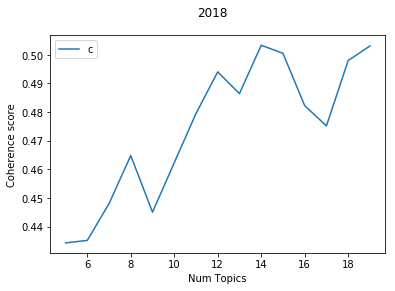

In [20]:
limit=20; start=5; step=1;
x = range(start, limit, step)
plt.figure().suptitle('2018')
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Evaluation

In [21]:
pyLDAvis.enable_notebook()
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model_list[3])
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.034508  0.087258       1        1  13.795503
5      0.087447 -0.202193       2        1  13.794974
4     -0.075113 -0.213362       3        1  13.515239
1      0.250271  0.134542       4        1  12.779127
3      0.153646  0.065546       5        1  12.446982
7     -0.343259  0.048830       6        1  11.954348
0      0.030505 -0.169244       7        1  11.641639
2     -0.068990  0.248622       8        1  10.072187, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
207   Default  16400.000000       woman  16400.000000  30.0000  30.0000
187   Default  12319.000000      police  12319.000000  29.0000  29.0000
469   Default   7493.000000     service   7493.000000  28.0000  28.0000
29    Default   9004.000000   community   9004.000000  27.0000  27.0000
159   Default   5890.000000       court   5890.000000  26.0000  26.0000
424   Default   8043.000000       child   8043.000000  25.0000  25.0000
475   Default   6031.000000     support   6031.000000  24.0000  24.0000
180   Default   4771.000000         man   4771.000000  23.0000  23.0000
182   Default   3763.000000         men   3763.000000  22.0000  22.0000
95    Default  11068.000000      people  11068.000000  21.0000  21.0000
297   Default   3354.000000       crime   3354.000000  20.0000  20.0000
155   Default   3008.000000      charge   3008.000000  19.0000  19.0000
390   Default   4264.000000      report   4264.000000  18.0000  18.0000
748   Default   3031.000000     program   3031.000000  17.0000  17.0000
84    Default   8136.000000          mr   8136.000000  16.0000  16.0000
443   Default   5218.000000  government   5218.000000  15.0000  15.0000
743   Default   3305.000000    per_cent   3305.000000  14.0000  14.0000
1415  Default   3026.000000     officer   3026.000000  13.0000  13.0000
643   Default   2328.000000         law   2328.000000  12.0000  12.0000
173   Default   4309.000000        home   4309.000000  11.0000  11.0000
556   Default   3855.000000       local   3855.000000  10.0000  10.0000
54    Default   3002.000000      health   3002.000000   9.0000   9.0000
206   Default   4400.000000      victim   4400.000000   8.0000   8.0000
244   Default   2455.000000    increase   2455.000000   7.0000   7.0000
83    Default   2063.000000      mother   2063.000000   6.0000   6.0000
174   Default   2459.000000    incident   2459.000000   5.0000   5.0000
140   Default   2212.000000     yearold   2212.000000   4.0000   4.0000
2656  Default   2810.000000         nsw   2810.000000   3.0000   3.0000
1799  Default   2154.000000       event   2154.000000   2.0000   2.0000
542   Default   4054.000000       house   4054.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
1415   Topic8   2169.589531     officer   3026.139441   1.9626  -4.2124
187    Topic8   7305.712114      police  12319.609470   1.7729  -2.9983
1462   Topic8    586.407697        rate    726.982768   2.0805  -5.5207
743    Topic8   2107.737197    per_cent   3305.439304   1.8454  -4.2414
147    Topic8   1541.550456        area   2312.645052   1.8898  -4.5542
244    Topic8   1621.244808    increase   2455.083267   1.8804  -4.5038
390    Topic8   2554.977145      report   4264.024604   1.7832  -4.0489
4613   Topic8    512.660684        drop    641.261869   2.0716  -5.6551
632    Topic8    648.260030      figure    870.420374   2.0007  -5.4204
174    Topic8   1498.729610    incident   2459.736114   1.8000  -4.5823
556    Topic8   2114.874005       local   3855.026212   1.6950  -4.2380
1663   Topic8    745.796401     station   1051.076717   1.9523  -5.2803
2444   Topic8    638.744286    offender    888.697284   1.9651  -5.4352
2656   Topic8   1517.761097         nsw   2810.041573   1.6794  -4.5697
3057   Topic8    555.481530      

In [358]:
pyLDAvis.save_html(vis, 'output/html/2014_13_clusters.html')

### Find the most representative document for each topic

In [18]:
from pprint import pprint
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.011*"year" + 0.011*"mr" + 0.008*"service" + 0.006*"play" + 0.005*"nsw" + '
  '0.005*"game" + 0.005*"work" + 0.005*"club" + 0.005*"award" + '
  '0.004*"community"'),
 (1,
  '0.029*"service" + 0.025*"people" + 0.025*"child" + 0.016*"support" + '
  '0.014*"health" + 0.012*"government" + 0.010*"year" + 0.009*"house" + '
  '0.009*"program" + 0.009*"work"'),
 (2,
  '0.029*"court" + 0.024*"man" + 0.015*"police" + 0.014*"charge" + 0.014*"mr" '
  '+ 0.011*"yearold" + 0.009*"home" + 0.009*"hear" + 0.008*"victim" + '
  '0.007*"sentence"'),
 (3,
  '0.058*"police" + 0.021*"crime" + 0.018*"report" + 0.017*"officer" + '
  '0.016*"year" + 0.012*"per_cent" + 0.011*"incident" + 0.011*"nsw" + '
  '0.011*"victim" + 0.010*"increase"'),
 (4,
  '0.011*"mr" + 0.011*"government" + 0.009*"law" + 0.007*"pay" + 0.005*"labor" '
  '+ 0.005*"party" + 0.005*"state" + 0.005*"million" + 0.005*"public" + '
  '0.005*"year"'),
 (5,
  '0.043*"woman" + 0.014*"men" + 0.011*"abuse" + 0.008*"life" + 0.007*"feel" + '


In [ ]:
# Finding the dominant topic in each Tweet


def format_topics_sentences(ldamodel, corpus=corpus, texts=data_filtered):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_filtered)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



In [ ]:
# # Show
len(df_dominant_topic)

### Compute dominant topic for each Tweet

In [ ]:
# Group top 40 Tweets under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(40)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# # Format
# sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

## Most dominant topics and number of documents for each:

In [ ]:
# Number of Documents for Each Topic
series_topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

idx = []
topic_counts = []
keywords = []
topic_contributions = []

for (i, count) in series_topic_counts.iteritems():
    idx.append(int(i))
    keywords.append(", ".join([word for word, _ in optimal_model.show_topic(int(i))]))
    topic_counts.append(count)
    topic_contributions.append(str(round(100*count/series_topic_counts.sum(), 2))+'%')
    
df_dominant_topics = pd.DataFrame.from_dict({
    'Dominant_Topic_Num': idx,
    'Topic_Keywords': keywords, 
    'Num_Documents': topic_counts, 
    'Perc_Documents': topic_contributions
})

# Show
pd.options.display.max_colwidth = 100
df_dominant_topics.set_index('Dominant_Topic_Num', inplace=True)
df_dominant_topics

# DF to Excel

In [ ]:
from pandas import ExcelWriter

writer = ExcelWriter('output/2014/data/2014_13_clusters.xlsx')
new_df = df_dominant_topics.copy()
new_df.index += 1
new_df.to_excel(writer,'topic_rank')

for topic_no in range(13):
    new_df = sent_topics_sorteddf_mallet.iloc[topic_no*40:((topic_no+1)*40),[0,4]]
    new_df.set_index('Document_No', inplace=True)
    
    replied_texts = []
    for i, row in new_df.iterrows():
        if replied_ids[indices[i]]:
            try:
                text = api.get_status(replied_ids[indices[i]], tweet_mode='extended').full_text
                replied_texts.append(text)
            except:
                replied_texts.append('')
        else:
            replied_texts.append('')
            
    new_df['In_Reply_To'] = replied_texts
    
    new_df.reset_index(inplace=True)
    new_df.drop(['Document_No'], axis=1, inplace=True)
    new_df.to_excel(writer,'topic_'+str(topic_no+1))
    
writer.save()